In [1]:
!pip install transformers torch pandas numpy matplotlib scikit-learn tqdm accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import warnings
import gc
warnings.filterwarnings('ignore')


os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:256'


import psutil
total_ram = psutil.virtual_memory().total / (1024**3)
print(f"Available RAM: {total_ram:.1f} GB")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU: {torch.cuda.get_device_name()}")
else:
    print("Using CPU")

print(f"Using device: {device}")

# Runnign based on my memory.
if total_ram < 13:
    MAX_LENGTH = 128
    BATCH_SIZE = 1
    ACCUMULATION_STEPS = 8
    print("Intense memory mode.")
elif total_ram < 26:
    MAX_LENGTH = 256
    BATCH_SIZE = 2
    ACCUMULATION_STEPS = 4
    print("Aggressive memory mode.")
else:
    MAX_LENGTH = 384
    BATCH_SIZE = 4
    ACCUMULATION_STEPS = 2
    print("Balanced memory mode.")

Available RAM: 53.0 GB
GPU: NVIDIA L4
Using device: cuda
Balanced memory mode.


In [3]:
# GPT-2 model.
class SimpleGPT2Classifier(nn.Module):
    def __init__(self, model_name='gpt2', num_classes=2):
        super(SimpleGPT2Classifier, self).__init__()

        # Loading the GPT-2 model.
        self.gpt2 = GPT2Model.from_pretrained(model_name)

        # Freezing most layers.
        for i, layer in enumerate(self.gpt2.h):
            if i < 10:
                for param in layer.parameters():
                    param.requires_grad = False

        # Gradient checkpoint.
        self.gpt2.gradient_checkpointing_enable()

        # Classification head.
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, num_classes)

        print("Training the last 2 layers.")

    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        # Using mean pooling.
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * mask, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            pooled = sum_embeddings / sum_mask
        else:
            pooled = torch.mean(last_hidden_state, dim=1)

        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits

# IMDBD dataset.
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


def load_data():
    from google.colab import files
    import io

    print("Upload your CSV files:")

    # Train file.
    print("Upload train.csv")
    uploaded_train = files.upload()
    train_filename = list(uploaded_train.keys())[0]
    train_df = pd.read_csv(io.BytesIO(uploaded_train[train_filename]))

    # Validation file.
    print("Upload validation.csv")
    uploaded_val = files.upload()
    val_filename = list(uploaded_val.keys())[0]
    val_df = pd.read_csv(io.BytesIO(uploaded_val[val_filename]))

    # Test file.
    print("Upload test.csv")
    uploaded_test = files.upload()
    test_filename = list(uploaded_test.keys())[0]
    test_df = pd.read_csv(io.BytesIO(uploaded_test[test_filename]))

    # Cleaning the data.
    train_df = train_df.dropna()
    val_df = val_df.dropna()
    test_df = test_df.dropna()

    print(f"Loaded: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test samples.")

    del uploaded_train, uploaded_val, uploaded_test
    gc.collect()

    return train_df, val_df, test_df

# Loading the data.
train_df, val_df, test_df = load_data()

# Tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

train_dataset = IMDBDataset(train_df['text'].values, train_df['label'].values, tokenizer, MAX_LENGTH)
val_dataset = IMDBDataset(val_df['text'].values, val_df['label'].values, tokenizer, MAX_LENGTH)
test_dataset = IMDBDataset(test_df['text'].values, test_df['label'].values, tokenizer, MAX_LENGTH)

# Creating data loaders.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = SimpleGPT2Classifier()
model = model.to(device)

# Counting the parameters.
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.1f}%)")

# Training setup.
LEARNING_RATE = 3e-5
NUM_EPOCHS = 3

optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training.
def train_epoch(model, dataloader, optimizer, criterion, device, accumulation_steps):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels) / accumulation_steps
            loss.backward()

            total_loss += loss.item() * accumulation_steps
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            if (step + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()

            # Memory cleanup.
            del input_ids, attention_mask, labels, logits
            if step % 100 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"OOM at step {step}, skipping...")
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                optimizer.zero_grad()
                continue
            else:
                print(f"Error at step {step}: {e}")
                continue

    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

                total_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

                del input_ids, attention_mask, labels, logits

            except RuntimeError as e:
                if "out of memory" in str(e):
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    continue
                else:
                    continue

    return total_loss / len(dataloader), correct / total

# Training loop.
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Training.")
print("=" * 50)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    # Clearing memory.
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()

    # Training.
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, ACCUMULATION_STEPS)

    # Validating.
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Results.
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining finish.")

Upload your CSV files:
Upload train.csv


Saving train.csv to train.csv
Upload validation.csv


Saving validation.csv to validation.csv
Upload test.csv


Saving test.csv to test.csv
Loaded: 35000 train, 5000 val, 10000 test samples.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Training the last 2 layers.
Trainable: 53,562,626 / 124,441,346 (43.0%)
Training.

Epoch 1/3


Evaluating: 100%|██████████| 1250/1250 [00:58<00:00, 21.35it/s]


Train Loss: 0.3684, Train Acc: 0.8726
Val Loss: 0.2656, Val Acc: 0.9126

Epoch 2/3


Evaluating: 100%|██████████| 1250/1250 [00:58<00:00, 21.49it/s]


Train Loss: 0.2746, Train Acc: 0.9130
Val Loss: 0.2771, Val Acc: 0.9214

Epoch 3/3


Evaluating: 100%|██████████| 1250/1250 [00:58<00:00, 21.34it/s]

Train Loss: 0.2453, Train Acc: 0.9278
Val Loss: 0.3095, Val Acc: 0.9248

Training finish.


Evaluating the test set.


Evaluating: 100%|██████████| 2500/2500 [01:57<00:00, 21.20it/s]



Final Results:
Training Accuracy: 92.78%
Validation Accuracy: 92.48%
Test Accuracy: 92.21%


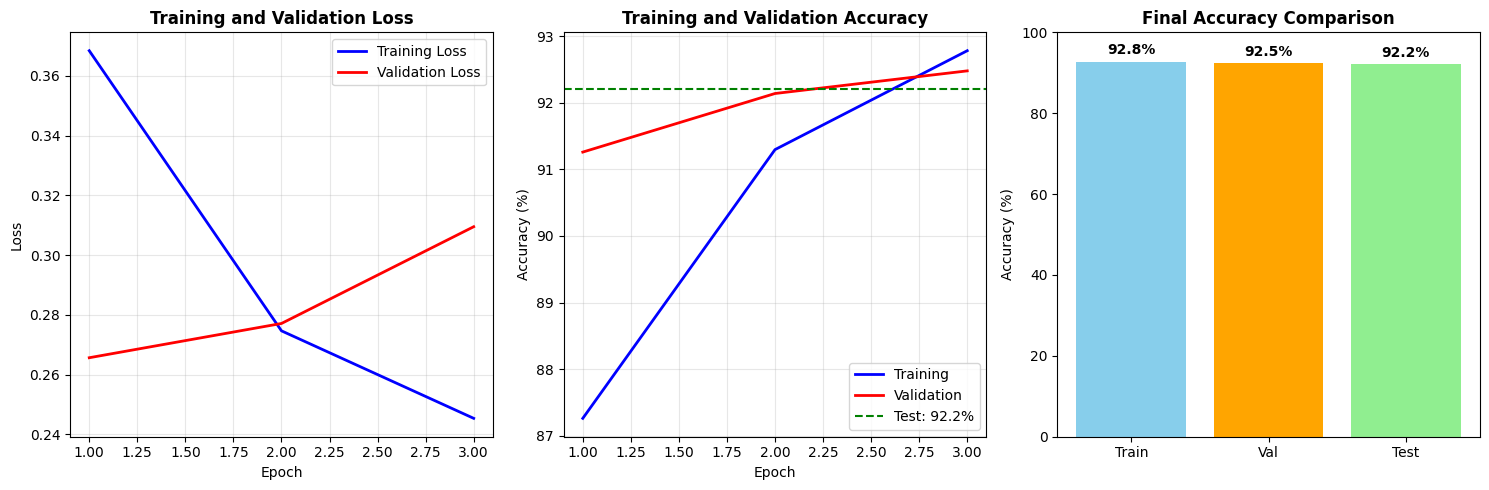


 Predictions:
Review 1: Positive (Confidence: 1.000)
Text: This movie was absolutely amazing! Great acting and wonderful story.

Review 2: Negative (Confidence: 1.000)
Text: Terrible film. Boring and poorly made.

Review 3: Positive (Confidence: 0.984)
Text: The movie was decent, nothing special but watchable.

Review 4: Positive (Confidence: 1.000)
Text: Outstanding performances by all the actors!


GPT-2 IMDB Sentiment Analysis Results

Dataset: 35,000 training samples.
Model: GPT-2 with 53,562,626 trainable parameters.
Configuration: max_len=384, batch=4, epochs=3

Final Results:
- Training Accuracy: 92.78%
- Validation Accuracy: 92.48%
- Test Accuracy: 92.21%

Files saved:
- gpt2_imdb_model.pt (model weights)
- training_results.pt (training history)

Training completed.
Final test accuracy: 92.21%


In [4]:
# Evaluation.
print("Evaluating the test set.")
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"\nFinal Results:")
print(f"Training Accuracy: {train_accuracies[-1]*100:.2f}%")
print(f"Validation Accuracy: {val_accuracies[-1]*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Visuals.
plt.figure(figsize=(15, 5))

# Loss plot.
plt.subplot(1, 3, 1)
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot.
plt.subplot(1, 3, 2)
plt.plot(epochs, [acc*100 for acc in train_accuracies], 'b-', label='Training', linewidth=2)
plt.plot(epochs, [acc*100 for acc in val_accuracies], 'r-', label='Validation', linewidth=2)
plt.axhline(y=test_acc*100, color='g', linestyle='--', label=f'Test: {test_acc*100:.1f}%')
plt.title('Training and Validation Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Summary bars.
plt.subplot(1, 3, 3)
categories = ['Train', 'Val', 'Test']
values = [train_accuracies[-1]*100, val_accuracies[-1]*100, test_acc*100]
colors = ['skyblue', 'orange', 'lightgreen']
bars = plt.bar(categories, values, color=colors)
plt.title('Final Accuracy Comparison', fontweight='bold')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Testing predictions.
def predict_sentiment(text, model, tokenizer, device, max_length):
    model.eval()
    encoding = tokenizer(text, truncation=True, padding='max_length',
                        max_length=max_length, return_tensors='pt')

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0][prediction].item()

    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment, confidence

# Examples.
sample_reviews = [
    "This movie was absolutely amazing! Great acting and wonderful story.",
    "Terrible film. Boring and poorly made.",
    "The movie was decent, nothing special but watchable.",
    "Outstanding performances by all the actors!"
]

print("\n Predictions:")
print("=" * 50)
for i, review in enumerate(sample_reviews, 1):
    sentiment, confidence = predict_sentiment(review, model, tokenizer, device, MAX_LENGTH)
    print(f"Review {i}: {sentiment} (Confidence: {confidence:.3f})")
    print(f"Text: {review}")
    print()


# Saving the results.
torch.save(model.state_dict(), '/content/gpt2_imdb_model.pt')

results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_accuracy': test_acc,
    'config': {
        'max_length': MAX_LENGTH,
        'batch_size': BATCH_SIZE,
        'accumulation_steps': ACCUMULATION_STEPS,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'trainable_params': trainable_params,
        'total_samples': len(train_df)
    }
}

torch.save(results, '/content/training_results.pt')

# Summary report.
summary = f"""
GPT-2 IMDB Sentiment Analysis Results
====================================

Dataset: {len(train_df):,} training samples.
Model: GPT-2 with {trainable_params:,} trainable parameters.
Configuration: max_len={MAX_LENGTH}, batch={BATCH_SIZE}, epochs={NUM_EPOCHS}

Final Results:
- Training Accuracy: {train_accuracies[-1]*100:.2f}%
- Validation Accuracy: {val_accuracies[-1]*100:.2f}%
- Test Accuracy: {test_acc*100:.2f}%

Files saved:
- gpt2_imdb_model.pt (model weights)
- training_results.pt (training history)
"""

print(summary)

torch.cuda.empty_cache() if torch.cuda.is_available() else None
gc.collect()

print("Training completed.")
print(f"Final test accuracy: {test_acc*100:.2f}%")